In [1]:
!pip install pillow matplotlib
!pip install tensorflow-gpu==2.0.0
!pip install 'h5py==2.10.0' --force-reinstall

  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached numpy-1.21.2-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.2
    Uninstalling numpy-1.21.2:
      Successfully uninstalled numpy-1.21.2
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires gast==0.4.0, but you have gast 0.2.2 which is incompatible.
tensorflow 2.6.0 requires h5py~=3.1.0, but you have h5py 2.10.0 which is incom

In [2]:
%%bash
wget https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb

dpkg -i nvidia-machine-learning-repo-*.deb
apt-get update

sudo apt-get install libnvinfer5

(Reading database ... 148581 files and directories currently installed.)
Preparing to unpack nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb ...
Unpacking nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) over (1.0.0-1) ...
Setting up nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) ...
Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:9 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Ign:10 https://developer.d

--2021-08-18 06:47:56--  https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.199.20.126
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.199.20.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2926 (2.9K) [application/x-deb]
Saving to: ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb.1’

     0K ..                                                    100%  119M=0s

2021-08-18 06:47:56 (119 MB/s) - ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb.1’ saved [2926/2926]

W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1 and /etc/apt/sources.list.d/nvidia-ml.list:1
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1

In [3]:
print("TensorRT version: ")
!dpkg -l | grep nvinfer

TensorRT version: 
ii  libnvinfer-dev                          8.0.1-1+cuda11.3                    amd64        TensorRT development libraries and headers
ii  libnvinfer-plugin-dev                   8.0.1-1+cuda11.3                    amd64        TensorRT plugin libraries
ii  libnvinfer-plugin8                      8.0.1-1+cuda11.3                    amd64        TensorRT plugin libraries
ii  libnvinfer5                             5.1.5-1+cuda10.1                    amd64        TensorRT runtime libraries
ii  libnvinfer8                             8.0.1-1+cuda11.3                    amd64        TensorRT runtime libraries
ii  python3-libnvinfer                      8.0.1-1+cuda11.3                    amd64        Python 3 bindings for TensorRT
ii  python3-libnvinfer-dev                  8.0.1-1+cuda11.3                    amd64        Python 3 development package for TensorRT


In [2]:
import tensorflow as tf
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
import numpy as np
import time
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.preprocessing import image
import os

In [3]:
def accuracy(true, pred):
    return sum(pred == true) / len(pred)

In [4]:
def load_tf_saved_model(model_dir):
    print('Loading saved model {}...'.format(model_dir))
    #saved_model_loaded = keras.models.load_model(model_dir)
    saved_model_loaded = tf.saved_model.load(model_dir, tags=[tag_constants.SERVING])
    infer = saved_model_loaded.signatures['serving_default']
    return infer

def compute_inference_time(infer, data, n_iters):
    n_photos = data.shape[0]
    elapsed_time = []
    for _ in range(10):
        softmax_pred = infer(data)
    for _ in range(n_iters):
        start_time = time.time()
        softmax_pred = infer(data)
        end_time = time.time()
        pred = tf.argmax(softmax_pred['dense_1'], axis=1)
        elapsed_time.append(end_time - start_time)
    print('Inference: {:.0f} images/s'.format(n_iters * n_photos / sum(elapsed_time)))

In [5]:
def convert_to_trt_graph_and_save(
    precision_mode='float32',
    input_saved_model_dir='tf_simple_model',
    max_batch_size=1,
    minimum_segment_size=3,
    calibration_data=None
):
    
    if precision_mode == 'float32':
        precision_mode = trt.TrtPrecisionMode.FP32
        converted_save_suffix = '_TFTRT_FP32'
        
    if precision_mode == 'float16':
        precision_mode = trt.TrtPrecisionMode.FP16
        converted_save_suffix = '_TFTRT_FP16'

    if precision_mode == 'int8':
        precision_mode = trt.TrtPrecisionMode.INT8
        converted_save_suffix = '_TFTRT_INT8'
        
    if minimum_segment_size != 3:
        converted_save_suffix += '_MSS_{}'.format(str(minimum_segment_size))
        
    output_saved_model_dir = input_saved_model_dir + converted_save_suffix
    
    conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
        precision_mode=precision_mode, 
        max_workspace_size_bytes=8000000000,
        minimum_segment_size=minimum_segment_size
    )

    converter = trt.TrtGraphConverterV2(
        input_saved_model_dir=input_saved_model_dir,
        conversion_params=conversion_params
    )

    print('Converting {} to TF-TRT graph precision mode {}...'.format(input_saved_model_dir, precision_mode))
    
    if precision_mode == trt.TrtPrecisionMode.INT8:
        def calibration_input_fn():
            yield (calibration_data, )
            
        converter.convert(calibration_input_fn=calibration_input_fn)
    
    else:
        converter.convert()

    print('Saving converted model to {}...'.format(output_saved_model_dir))
    converter.save(output_saved_model_dir=output_saved_model_dir)
    del converter
    print('Complete')

Оптимизация Tensorflow

In [6]:
!mkdir ./data
!wget  -O ./data/img0.jpg "https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630"
!wget  -O ./data/img1.jpg "https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg"
!wget  -O ./data/img2.jpg "https://www.artis.nl/media/filer_public_thumbnails/filer_public/00/f1/00f1b6db-fbed-4fef-9ab0-84e944ff11f8/chimpansee_amber_r_1920x1080.jpg__1920x1080_q85_subject_location-923%2C365_subsampling-2.jpg"
!wget  -O ./data/img3.jpg "https://www.familyhandyman.com/wp-content/uploads/2018/09/How-to-Avoid-Snakes-Slithering-Up-Your-Toilet-shutterstock_780480850.jpg"
!wget  -O ./data/img4.jpg "https://get.wallhere.com/photo/animals-horse-grass-pony-Colt-tree-grassland-livestock-Rein-pasture-foal-meadow-mare-1680x1050-px-snout-mane-horse-like-mammal-stallion-mustang-horse-bridle-ecoregion-772272.jpg"
!wget  -O ./data/img5.jpg "https://lookw.ru/8/828/1476173549-33711.jpg"
!wget  -O ./data/img6.jpg "https://i.pinimg.com/originals/2b/f3/3d/2bf33da3661b1066c0f1802698c9c82b.jpg"
!wget  -O ./data/img7.jpg "http://patroquephoto.com/wp-content/uploads/2014/11/Delilah.jpg"

mkdir: cannot create directory ‘./data’: File exists
--2021-08-18 06:56:42--  https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630
Resolving d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)... 52.84.193.68, 52.84.193.173, 52.84.193.42, ...
Connecting to d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)|52.84.193.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24112 (24K) [image/jpeg]
Saving to: ‘./data/img0.jpg’

./data/img0.jpg     100%[===================>]  23.55K  --.-KB/s    in 0s      

2021-08-18 06:56:42 (69.2 MB/s) - ‘./data/img0.jpg’ saved [24112/24112]

--2021-08-18 06:56:42--  https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg
Resolving www.hakaimagazine.com (www.hakaimagazine.com)... 23.185.0.4, 2620:12a:8001::4, 2620:12a:8000::4
Connecting to www.hakaimagazine.com (www.hakaimagazine.com)|23.185.0.4|:443... connected.
HTTP request sent, await

Давайте используем уже обученную модель Resnet50 на данных imagent и попробуем оптимизировать инференс модели

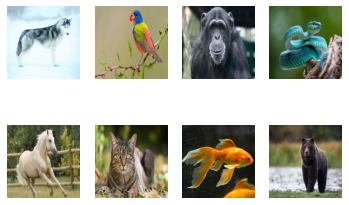

In [7]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

fig, axes = plt.subplots(nrows=4, ncols=2)

for i in range(8):
  img_path = './data/img%d.jpg'%i
  img = image.load_img(img_path, target_size=(224, 224))
  plt.subplot(2,4,i+1)
  plt.imshow(img);
  plt.axis('off');

Загрузим саму модель

In [11]:
model = keras.applications.ResNet50(weights='imagenet')

Это декодер ответов модели, можно через api tf дергать, но это если есть доступ в интернет)

In [8]:
decoder = {"0": ["n01440764", "tench"], "1": ["n01443537", "goldfish"], "2": ["n01484850", "great_white_shark"], "3": ["n01491361", "tiger_shark"], "4": ["n01494475", "hammerhead"], "5": ["n01496331", "electric_ray"], "6": ["n01498041", "stingray"], "7": ["n01514668", "cock"], "8": ["n01514859", "hen"], "9": ["n01518878", "ostrich"], "10": ["n01530575", "brambling"], "11": ["n01531178", "goldfinch"], "12": ["n01532829", "house_finch"], "13": ["n01534433", "junco"], "14": ["n01537544", "indigo_bunting"], "15": ["n01558993", "robin"], "16": ["n01560419", "bulbul"], "17": ["n01580077", "jay"], "18": ["n01582220", "magpie"], "19": ["n01592084", "chickadee"], "20": ["n01601694", "water_ouzel"], "21": ["n01608432", "kite"], "22": ["n01614925", "bald_eagle"], "23": ["n01616318", "vulture"], "24": ["n01622779", "great_grey_owl"], "25": ["n01629819", "European_fire_salamander"], "26": ["n01630670", "common_newt"], "27": ["n01631663", "eft"], "28": ["n01632458", "spotted_salamander"], "29": ["n01632777", "axolotl"], "30": ["n01641577", "bullfrog"], "31": ["n01644373", "tree_frog"], "32": ["n01644900", "tailed_frog"], "33": ["n01664065", "loggerhead"], "34": ["n01665541", "leatherback_turtle"], "35": ["n01667114", "mud_turtle"], "36": ["n01667778", "terrapin"], "37": ["n01669191", "box_turtle"], "38": ["n01675722", "banded_gecko"], "39": ["n01677366", "common_iguana"], "40": ["n01682714", "American_chameleon"], "41": ["n01685808", "whiptail"], "42": ["n01687978", "agama"], "43": ["n01688243", "frilled_lizard"], "44": ["n01689811", "alligator_lizard"], "45": ["n01692333", "Gila_monster"], "46": ["n01693334", "green_lizard"], "47": ["n01694178", "African_chameleon"], "48": ["n01695060", "Komodo_dragon"], "49": ["n01697457", "African_crocodile"], "50": ["n01698640", "American_alligator"], "51": ["n01704323", "triceratops"], "52": ["n01728572", "thunder_snake"], "53": ["n01728920", "ringneck_snake"], "54": ["n01729322", "hognose_snake"], "55": ["n01729977", "green_snake"], "56": ["n01734418", "king_snake"], "57": ["n01735189", "garter_snake"], "58": ["n01737021", "water_snake"], "59": ["n01739381", "vine_snake"], "60": ["n01740131", "night_snake"], "61": ["n01742172", "boa_constrictor"], "62": ["n01744401", "rock_python"], "63": ["n01748264", "Indian_cobra"], "64": ["n01749939", "green_mamba"], "65": ["n01751748", "sea_snake"], "66": ["n01753488", "horned_viper"], "67": ["n01755581", "diamondback"], "68": ["n01756291", "sidewinder"], "69": ["n01768244", "trilobite"], "70": ["n01770081", "harvestman"], "71": ["n01770393", "scorpion"], "72": ["n01773157", "black_and_gold_garden_spider"], "73": ["n01773549", "barn_spider"], "74": ["n01773797", "garden_spider"], "75": ["n01774384", "black_widow"], "76": ["n01774750", "tarantula"], "77": ["n01775062", "wolf_spider"], "78": ["n01776313", "tick"], "79": ["n01784675", "centipede"], "80": ["n01795545", "black_grouse"], "81": ["n01796340", "ptarmigan"], "82": ["n01797886", "ruffed_grouse"], "83": ["n01798484", "prairie_chicken"], "84": ["n01806143", "peacock"], "85": ["n01806567", "quail"], "86": ["n01807496", "partridge"], "87": ["n01817953", "African_grey"], "88": ["n01818515", "macaw"], "89": ["n01819313", "sulphur-crested_cockatoo"], "90": ["n01820546", "lorikeet"], "91": ["n01824575", "coucal"], "92": ["n01828970", "bee_eater"], "93": ["n01829413", "hornbill"], "94": ["n01833805", "hummingbird"], "95": ["n01843065", "jacamar"], "96": ["n01843383", "toucan"], "97": ["n01847000", "drake"], "98": ["n01855032", "red-breasted_merganser"], "99": ["n01855672", "goose"], "100": ["n01860187", "black_swan"], "101": ["n01871265", "tusker"], "102": ["n01872401", "echidna"], "103": ["n01873310", "platypus"], "104": ["n01877812", "wallaby"], "105": ["n01882714", "koala"], "106": ["n01883070", "wombat"], "107": ["n01910747", "jellyfish"], "108": ["n01914609", "sea_anemone"], "109": ["n01917289", "brain_coral"], "110": ["n01924916", "flatworm"], "111": ["n01930112", "nematode"], "112": ["n01943899", "conch"], "113": ["n01944390", "snail"], "114": ["n01945685", "slug"], "115": ["n01950731", "sea_slug"], "116": ["n01955084", "chiton"], "117": ["n01968897", "chambered_nautilus"], "118": ["n01978287", "Dungeness_crab"], "119": ["n01978455", "rock_crab"], "120": ["n01980166", "fiddler_crab"], "121": ["n01981276", "king_crab"], "122": ["n01983481", "American_lobster"], "123": ["n01984695", "spiny_lobster"], "124": ["n01985128", "crayfish"], "125": ["n01986214", "hermit_crab"], "126": ["n01990800", "isopod"], "127": ["n02002556", "white_stork"], "128": ["n02002724", "black_stork"], "129": ["n02006656", "spoonbill"], "130": ["n02007558", "flamingo"], "131": ["n02009229", "little_blue_heron"], "132": ["n02009912", "American_egret"], "133": ["n02011460", "bittern"], "134": ["n02012849", "crane"], "135": ["n02013706", "limpkin"], "136": ["n02017213", "European_gallinule"], "137": ["n02018207", "American_coot"], "138": ["n02018795", "bustard"], "139": ["n02025239", "ruddy_turnstone"], "140": ["n02027492", "red-backed_sandpiper"], "141": ["n02028035", "redshank"], "142": ["n02033041", "dowitcher"], "143": ["n02037110", "oystercatcher"], "144": ["n02051845", "pelican"], "145": ["n02056570", "king_penguin"], "146": ["n02058221", "albatross"], "147": ["n02066245", "grey_whale"], "148": ["n02071294", "killer_whale"], "149": ["n02074367", "dugong"], "150": ["n02077923", "sea_lion"], "151": ["n02085620", "Chihuahua"], "152": ["n02085782", "Japanese_spaniel"], "153": ["n02085936", "Maltese_dog"], "154": ["n02086079", "Pekinese"], "155": ["n02086240", "Shih-Tzu"], "156": ["n02086646", "Blenheim_spaniel"], "157": ["n02086910", "papillon"], "158": ["n02087046", "toy_terrier"], "159": ["n02087394", "Rhodesian_ridgeback"], "160": ["n02088094", "Afghan_hound"], "161": ["n02088238", "basset"], "162": ["n02088364", "beagle"], "163": ["n02088466", "bloodhound"], "164": ["n02088632", "bluetick"], "165": ["n02089078", "black-and-tan_coonhound"], "166": ["n02089867", "Walker_hound"], "167": ["n02089973", "English_foxhound"], "168": ["n02090379", "redbone"], "169": ["n02090622", "borzoi"], "170": ["n02090721", "Irish_wolfhound"], "171": ["n02091032", "Italian_greyhound"], "172": ["n02091134", "whippet"], "173": ["n02091244", "Ibizan_hound"], "174": ["n02091467", "Norwegian_elkhound"], "175": ["n02091635", "otterhound"], "176": ["n02091831", "Saluki"], "177": ["n02092002", "Scottish_deerhound"], "178": ["n02092339", "Weimaraner"], "179": ["n02093256", "Staffordshire_bullterrier"], "180": ["n02093428", "American_Staffordshire_terrier"], "181": ["n02093647", "Bedlington_terrier"], "182": ["n02093754", "Border_terrier"], "183": ["n02093859", "Kerry_blue_terrier"], "184": ["n02093991", "Irish_terrier"], "185": ["n02094114", "Norfolk_terrier"], "186": ["n02094258", "Norwich_terrier"], "187": ["n02094433", "Yorkshire_terrier"], "188": ["n02095314", "wire-haired_fox_terrier"], "189": ["n02095570", "Lakeland_terrier"], "190": ["n02095889", "Sealyham_terrier"], "191": ["n02096051", "Airedale"], "192": ["n02096177", "cairn"], "193": ["n02096294", "Australian_terrier"], "194": ["n02096437", "Dandie_Dinmont"], "195": ["n02096585", "Boston_bull"], "196": ["n02097047", "miniature_schnauzer"], "197": ["n02097130", "giant_schnauzer"], "198": ["n02097209", "standard_schnauzer"], "199": ["n02097298", "Scotch_terrier"], "200": ["n02097474", "Tibetan_terrier"], "201": ["n02097658", "silky_terrier"], "202": ["n02098105", "soft-coated_wheaten_terrier"], "203": ["n02098286", "West_Highland_white_terrier"], "204": ["n02098413", "Lhasa"], "205": ["n02099267", "flat-coated_retriever"], "206": ["n02099429", "curly-coated_retriever"], "207": ["n02099601", "golden_retriever"], "208": ["n02099712", "Labrador_retriever"], "209": ["n02099849", "Chesapeake_Bay_retriever"], "210": ["n02100236", "German_short-haired_pointer"], "211": ["n02100583", "vizsla"], "212": ["n02100735", "English_setter"], "213": ["n02100877", "Irish_setter"], "214": ["n02101006", "Gordon_setter"], "215": ["n02101388", "Brittany_spaniel"], "216": ["n02101556", "clumber"], "217": ["n02102040", "English_springer"], "218": ["n02102177", "Welsh_springer_spaniel"], "219": ["n02102318", "cocker_spaniel"], "220": ["n02102480", "Sussex_spaniel"], "221": ["n02102973", "Irish_water_spaniel"], "222": ["n02104029", "kuvasz"], "223": ["n02104365", "schipperke"], "224": ["n02105056", "groenendael"], "225": ["n02105162", "malinois"], "226": ["n02105251", "briard"], "227": ["n02105412", "kelpie"], "228": ["n02105505", "komondor"], "229": ["n02105641", "Old_English_sheepdog"], "230": ["n02105855", "Shetland_sheepdog"], "231": ["n02106030", "collie"], "232": ["n02106166", "Border_collie"], "233": ["n02106382", "Bouvier_des_Flandres"], "234": ["n02106550", "Rottweiler"], "235": ["n02106662", "German_shepherd"], "236": ["n02107142", "Doberman"], "237": ["n02107312", "miniature_pinscher"], "238": ["n02107574", "Greater_Swiss_Mountain_dog"], "239": ["n02107683", "Bernese_mountain_dog"], "240": ["n02107908", "Appenzeller"], "241": ["n02108000", "EntleBucher"], "242": ["n02108089", "boxer"], "243": ["n02108422", "bull_mastiff"], "244": ["n02108551", "Tibetan_mastiff"], "245": ["n02108915", "French_bulldog"], "246": ["n02109047", "Great_Dane"], "247": ["n02109525", "Saint_Bernard"], "248": ["n02109961", "Eskimo_dog"], "249": ["n02110063", "malamute"], "250": ["n02110185", "Siberian_husky"], "251": ["n02110341", "dalmatian"], "252": ["n02110627", "affenpinscher"], "253": ["n02110806", "basenji"], "254": ["n02110958", "pug"], "255": ["n02111129", "Leonberg"], "256": ["n02111277", "Newfoundland"], "257": ["n02111500", "Great_Pyrenees"], "258": ["n02111889", "Samoyed"], "259": ["n02112018", "Pomeranian"], "260": ["n02112137", "chow"], "261": ["n02112350", "keeshond"], "262": ["n02112706", "Brabancon_griffon"], "263": ["n02113023", "Pembroke"], "264": ["n02113186", "Cardigan"], "265": ["n02113624", "toy_poodle"], "266": ["n02113712", "miniature_poodle"], "267": ["n02113799", "standard_poodle"], "268": ["n02113978", "Mexican_hairless"], "269": ["n02114367", "timber_wolf"], "270": ["n02114548", "white_wolf"], "271": ["n02114712", "red_wolf"], "272": ["n02114855", "coyote"], "273": ["n02115641", "dingo"], "274": ["n02115913", "dhole"], "275": ["n02116738", "African_hunting_dog"], "276": ["n02117135", "hyena"], "277": ["n02119022", "red_fox"], "278": ["n02119789", "kit_fox"], "279": ["n02120079", "Arctic_fox"], "280": ["n02120505", "grey_fox"], "281": ["n02123045", "tabby"], "282": ["n02123159", "tiger_cat"], "283": ["n02123394", "Persian_cat"], "284": ["n02123597", "Siamese_cat"], "285": ["n02124075", "Egyptian_cat"], "286": ["n02125311", "cougar"], "287": ["n02127052", "lynx"], "288": ["n02128385", "leopard"], "289": ["n02128757", "snow_leopard"], "290": ["n02128925", "jaguar"], "291": ["n02129165", "lion"], "292": ["n02129604", "tiger"], "293": ["n02130308", "cheetah"], "294": ["n02132136", "brown_bear"], "295": ["n02133161", "American_black_bear"], "296": ["n02134084", "ice_bear"], "297": ["n02134418", "sloth_bear"], "298": ["n02137549", "mongoose"], "299": ["n02138441", "meerkat"], "300": ["n02165105", "tiger_beetle"], "301": ["n02165456", "ladybug"], "302": ["n02167151", "ground_beetle"], "303": ["n02168699", "long-horned_beetle"], "304": ["n02169497", "leaf_beetle"], "305": ["n02172182", "dung_beetle"], "306": ["n02174001", "rhinoceros_beetle"], "307": ["n02177972", "weevil"], "308": ["n02190166", "fly"], "309": ["n02206856", "bee"], "310": ["n02219486", "ant"], "311": ["n02226429", "grasshopper"], "312": ["n02229544", "cricket"], "313": ["n02231487", "walking_stick"], "314": ["n02233338", "cockroach"], "315": ["n02236044", "mantis"], "316": ["n02256656", "cicada"], "317": ["n02259212", "leafhopper"], "318": ["n02264363", "lacewing"], "319": ["n02268443", "dragonfly"], "320": ["n02268853", "damselfly"], "321": ["n02276258", "admiral"], "322": ["n02277742", "ringlet"], "323": ["n02279972", "monarch"], "324": ["n02280649", "cabbage_butterfly"], "325": ["n02281406", "sulphur_butterfly"], "326": ["n02281787", "lycaenid"], "327": ["n02317335", "starfish"], "328": ["n02319095", "sea_urchin"], "329": ["n02321529", "sea_cucumber"], "330": ["n02325366", "wood_rabbit"], "331": ["n02326432", "hare"], "332": ["n02328150", "Angora"], "333": ["n02342885", "hamster"], "334": ["n02346627", "porcupine"], "335": ["n02356798", "fox_squirrel"], "336": ["n02361337", "marmot"], "337": ["n02363005", "beaver"], "338": ["n02364673", "guinea_pig"], "339": ["n02389026", "sorrel"], "340": ["n02391049", "zebra"], "341": ["n02395406", "hog"], "342": ["n02396427", "wild_boar"], "343": ["n02397096", "warthog"], "344": ["n02398521", "hippopotamus"], "345": ["n02403003", "ox"], "346": ["n02408429", "water_buffalo"], "347": ["n02410509", "bison"], "348": ["n02412080", "ram"], "349": ["n02415577", "bighorn"], "350": ["n02417914", "ibex"], "351": ["n02422106", "hartebeest"], "352": ["n02422699", "impala"], "353": ["n02423022", "gazelle"], "354": ["n02437312", "Arabian_camel"], "355": ["n02437616", "llama"], "356": ["n02441942", "weasel"], "357": ["n02442845", "mink"], "358": ["n02443114", "polecat"], "359": ["n02443484", "black-footed_ferret"], "360": ["n02444819", "otter"], "361": ["n02445715", "skunk"], "362": ["n02447366", "badger"], "363": ["n02454379", "armadillo"], "364": ["n02457408", "three-toed_sloth"], "365": ["n02480495", "orangutan"], "366": ["n02480855", "gorilla"], "367": ["n02481823", "chimpanzee"], "368": ["n02483362", "gibbon"], "369": ["n02483708", "siamang"], "370": ["n02484975", "guenon"], "371": ["n02486261", "patas"], "372": ["n02486410", "baboon"], "373": ["n02487347", "macaque"], "374": ["n02488291", "langur"], "375": ["n02488702", "colobus"], "376": ["n02489166", "proboscis_monkey"], "377": ["n02490219", "marmoset"], "378": ["n02492035", "capuchin"], "379": ["n02492660", "howler_monkey"], "380": ["n02493509", "titi"], "381": ["n02493793", "spider_monkey"], "382": ["n02494079", "squirrel_monkey"], "383": ["n02497673", "Madagascar_cat"], "384": ["n02500267", "indri"], "385": ["n02504013", "Indian_elephant"], "386": ["n02504458", "African_elephant"], "387": ["n02509815", "lesser_panda"], "388": ["n02510455", "giant_panda"], "389": ["n02514041", "barracouta"], "390": ["n02526121", "eel"], "391": ["n02536864", "coho"], "392": ["n02606052", "rock_beauty"], "393": ["n02607072", "anemone_fish"], "394": ["n02640242", "sturgeon"], "395": ["n02641379", "gar"], "396": ["n02643566", "lionfish"], "397": ["n02655020", "puffer"], "398": ["n02666196", "abacus"], "399": ["n02667093", "abaya"], "400": ["n02669723", "academic_gown"], "401": ["n02672831", "accordion"], "402": ["n02676566", "acoustic_guitar"], "403": ["n02687172", "aircraft_carrier"], "404": ["n02690373", "airliner"], "405": ["n02692877", "airship"], "406": ["n02699494", "altar"], "407": ["n02701002", "ambulance"], "408": ["n02704792", "amphibian"], "409": ["n02708093", "analog_clock"], "410": ["n02727426", "apiary"], "411": ["n02730930", "apron"], "412": ["n02747177", "ashcan"], "413": ["n02749479", "assault_rifle"], "414": ["n02769748", "backpack"], "415": ["n02776631", "bakery"], "416": ["n02777292", "balance_beam"], "417": ["n02782093", "balloon"], "418": ["n02783161", "ballpoint"], "419": ["n02786058", "Band_Aid"], "420": ["n02787622", "banjo"], "421": ["n02788148", "bannister"], "422": ["n02790996", "barbell"], "423": ["n02791124", "barber_chair"], "424": ["n02791270", "barbershop"], "425": ["n02793495", "barn"], "426": ["n02794156", "barometer"], "427": ["n02795169", "barrel"], "428": ["n02797295", "barrow"], "429": ["n02799071", "baseball"], "430": ["n02802426", "basketball"], "431": ["n02804414", "bassinet"], "432": ["n02804610", "bassoon"], "433": ["n02807133", "bathing_cap"], "434": ["n02808304", "bath_towel"], "435": ["n02808440", "bathtub"], "436": ["n02814533", "beach_wagon"], "437": ["n02814860", "beacon"], "438": ["n02815834", "beaker"], "439": ["n02817516", "bearskin"], "440": ["n02823428", "beer_bottle"], "441": ["n02823750", "beer_glass"], "442": ["n02825657", "bell_cote"], "443": ["n02834397", "bib"], "444": ["n02835271", "bicycle-built-for-two"], "445": ["n02837789", "bikini"], "446": ["n02840245", "binder"], "447": ["n02841315", "binoculars"], "448": ["n02843684", "birdhouse"], "449": ["n02859443", "boathouse"], "450": ["n02860847", "bobsled"], "451": ["n02865351", "bolo_tie"], "452": ["n02869837", "bonnet"], "453": ["n02870880", "bookcase"], "454": ["n02871525", "bookshop"], "455": ["n02877765", "bottlecap"], "456": ["n02879718", "bow"], "457": ["n02883205", "bow_tie"], "458": ["n02892201", "brass"], "459": ["n02892767", "brassiere"], "460": ["n02894605", "breakwater"], "461": ["n02895154", "breastplate"], "462": ["n02906734", "broom"], "463": ["n02909870", "bucket"], "464": ["n02910353", "buckle"], "465": ["n02916936", "bulletproof_vest"], "466": ["n02917067", "bullet_train"], "467": ["n02927161", "butcher_shop"], "468": ["n02930766", "cab"], "469": ["n02939185", "caldron"], "470": ["n02948072", "candle"], "471": ["n02950826", "cannon"], "472": ["n02951358", "canoe"], "473": ["n02951585", "can_opener"], "474": ["n02963159", "cardigan"], "475": ["n02965783", "car_mirror"], "476": ["n02966193", "carousel"], "477": ["n02966687", "carpenter's_kit"], "478": ["n02971356", "carton"], "479": ["n02974003", "car_wheel"], "480": ["n02977058", "cash_machine"], "481": ["n02978881", "cassette"], "482": ["n02979186", "cassette_player"], "483": ["n02980441", "castle"], "484": ["n02981792", "catamaran"], "485": ["n02988304", "CD_player"], "486": ["n02992211", "cello"], "487": ["n02992529", "cellular_telephone"], "488": ["n02999410", "chain"], "489": ["n03000134", "chainlink_fence"], "490": ["n03000247", "chain_mail"], "491": ["n03000684", "chain_saw"], "492": ["n03014705", "chest"], "493": ["n03016953", "chiffonier"], "494": ["n03017168", "chime"], "495": ["n03018349", "china_cabinet"], "496": ["n03026506", "Christmas_stocking"], "497": ["n03028079", "church"], "498": ["n03032252", "cinema"], "499": ["n03041632", "cleaver"], "500": ["n03042490", "cliff_dwelling"], "501": ["n03045698", "cloak"], "502": ["n03047690", "clog"], "503": ["n03062245", "cocktail_shaker"], "504": ["n03063599", "coffee_mug"], "505": ["n03063689", "coffeepot"], "506": ["n03065424", "coil"], "507": ["n03075370", "combination_lock"], "508": ["n03085013", "computer_keyboard"], "509": ["n03089624", "confectionery"], "510": ["n03095699", "container_ship"], "511": ["n03100240", "convertible"], "512": ["n03109150", "corkscrew"], "513": ["n03110669", "cornet"], "514": ["n03124043", "cowboy_boot"], "515": ["n03124170", "cowboy_hat"], "516": ["n03125729", "cradle"], "517": ["n03126707", "crane"], "518": ["n03127747", "crash_helmet"], "519": ["n03127925", "crate"], "520": ["n03131574", "crib"], "521": ["n03133878", "Crock_Pot"], "522": ["n03134739", "croquet_ball"], "523": ["n03141823", "crutch"], "524": ["n03146219", "cuirass"], "525": ["n03160309", "dam"], "526": ["n03179701", "desk"], "527": ["n03180011", "desktop_computer"], "528": ["n03187595", "dial_telephone"], "529": ["n03188531", "diaper"], "530": ["n03196217", "digital_clock"], "531": ["n03197337", "digital_watch"], "532": ["n03201208", "dining_table"], "533": ["n03207743", "dishrag"], "534": ["n03207941", "dishwasher"], "535": ["n03208938", "disk_brake"], "536": ["n03216828", "dock"], "537": ["n03218198", "dogsled"], "538": ["n03220513", "dome"], "539": ["n03223299", "doormat"], "540": ["n03240683", "drilling_platform"], "541": ["n03249569", "drum"], "542": ["n03250847", "drumstick"], "543": ["n03255030", "dumbbell"], "544": ["n03259280", "Dutch_oven"], "545": ["n03271574", "electric_fan"], "546": ["n03272010", "electric_guitar"], "547": ["n03272562", "electric_locomotive"], "548": ["n03290653", "entertainment_center"], "549": ["n03291819", "envelope"], "550": ["n03297495", "espresso_maker"], "551": ["n03314780", "face_powder"], "552": ["n03325584", "feather_boa"], "553": ["n03337140", "file"], "554": ["n03344393", "fireboat"], "555": ["n03345487", "fire_engine"], "556": ["n03347037", "fire_screen"], "557": ["n03355925", "flagpole"], "558": ["n03372029", "flute"], "559": ["n03376595", "folding_chair"], "560": ["n03379051", "football_helmet"], "561": ["n03384352", "forklift"], "562": ["n03388043", "fountain"], "563": ["n03388183", "fountain_pen"], "564": ["n03388549", "four-poster"], "565": ["n03393912", "freight_car"], "566": ["n03394916", "French_horn"], "567": ["n03400231", "frying_pan"], "568": ["n03404251", "fur_coat"], "569": ["n03417042", "garbage_truck"], "570": ["n03424325", "gasmask"], "571": ["n03425413", "gas_pump"], "572": ["n03443371", "goblet"], "573": ["n03444034", "go-kart"], "574": ["n03445777", "golf_ball"], "575": ["n03445924", "golfcart"], "576": ["n03447447", "gondola"], "577": ["n03447721", "gong"], "578": ["n03450230", "gown"], "579": ["n03452741", "grand_piano"], "580": ["n03457902", "greenhouse"], "581": ["n03459775", "grille"], "582": ["n03461385", "grocery_store"], "583": ["n03467068", "guillotine"], "584": ["n03476684", "hair_slide"], "585": ["n03476991", "hair_spray"], "586": ["n03478589", "half_track"], "587": ["n03481172", "hammer"], "588": ["n03482405", "hamper"], "589": ["n03483316", "hand_blower"], "590": ["n03485407", "hand-held_computer"], "591": ["n03485794", "handkerchief"], "592": ["n03492542", "hard_disc"], "593": ["n03494278", "harmonica"], "594": ["n03495258", "harp"], "595": ["n03496892", "harvester"], "596": ["n03498962", "hatchet"], "597": ["n03527444", "holster"], "598": ["n03529860", "home_theater"], "599": ["n03530642", "honeycomb"], "600": ["n03532672", "hook"], "601": ["n03534580", "hoopskirt"], "602": ["n03535780", "horizontal_bar"], "603": ["n03538406", "horse_cart"], "604": ["n03544143", "hourglass"], "605": ["n03584254", "iPod"], "606": ["n03584829", "iron"], "607": ["n03590841", "jack-o'-lantern"], "608": ["n03594734", "jean"], "609": ["n03594945", "jeep"], "610": ["n03595614", "jersey"], "611": ["n03598930", "jigsaw_puzzle"], "612": ["n03599486", "jinrikisha"], "613": ["n03602883", "joystick"], "614": ["n03617480", "kimono"], "615": ["n03623198", "knee_pad"], "616": ["n03627232", "knot"], "617": ["n03630383", "lab_coat"], "618": ["n03633091", "ladle"], "619": ["n03637318", "lampshade"], "620": ["n03642806", "laptop"], "621": ["n03649909", "lawn_mower"], "622": ["n03657121", "lens_cap"], "623": ["n03658185", "letter_opener"], "624": ["n03661043", "library"], "625": ["n03662601", "lifeboat"], "626": ["n03666591", "lighter"], "627": ["n03670208", "limousine"], "628": ["n03673027", "liner"], "629": ["n03676483", "lipstick"], "630": ["n03680355", "Loafer"], "631": ["n03690938", "lotion"], "632": ["n03691459", "loudspeaker"], "633": ["n03692522", "loupe"], "634": ["n03697007", "lumbermill"], "635": ["n03706229", "magnetic_compass"], "636": ["n03709823", "mailbag"], "637": ["n03710193", "mailbox"], "638": ["n03710637", "maillot"], "639": ["n03710721", "maillot"], "640": ["n03717622", "manhole_cover"], "641": ["n03720891", "maraca"], "642": ["n03721384", "marimba"], "643": ["n03724870", "mask"], "644": ["n03729826", "matchstick"], "645": ["n03733131", "maypole"], "646": ["n03733281", "maze"], "647": ["n03733805", "measuring_cup"], "648": ["n03742115", "medicine_chest"], "649": ["n03743016", "megalith"], "650": ["n03759954", "microphone"], "651": ["n03761084", "microwave"], "652": ["n03763968", "military_uniform"], "653": ["n03764736", "milk_can"], "654": ["n03769881", "minibus"], "655": ["n03770439", "miniskirt"], "656": ["n03770679", "minivan"], "657": ["n03773504", "missile"], "658": ["n03775071", "mitten"], "659": ["n03775546", "mixing_bowl"], "660": ["n03776460", "mobile_home"], "661": ["n03777568", "Model_T"], "662": ["n03777754", "modem"], "663": ["n03781244", "monastery"], "664": ["n03782006", "monitor"], "665": ["n03785016", "moped"], "666": ["n03786901", "mortar"], "667": ["n03787032", "mortarboard"], "668": ["n03788195", "mosque"], "669": ["n03788365", "mosquito_net"], "670": ["n03791053", "motor_scooter"], "671": ["n03792782", "mountain_bike"], "672": ["n03792972", "mountain_tent"], "673": ["n03793489", "mouse"], "674": ["n03794056", "mousetrap"], "675": ["n03796401", "moving_van"], "676": ["n03803284", "muzzle"], "677": ["n03804744", "nail"], "678": ["n03814639", "neck_brace"], "679": ["n03814906", "necklace"], "680": ["n03825788", "nipple"], "681": ["n03832673", "notebook"], "682": ["n03837869", "obelisk"], "683": ["n03838899", "oboe"], "684": ["n03840681", "ocarina"], "685": ["n03841143", "odometer"], "686": ["n03843555", "oil_filter"], "687": ["n03854065", "organ"], "688": ["n03857828", "oscilloscope"], "689": ["n03866082", "overskirt"], "690": ["n03868242", "oxcart"], "691": ["n03868863", "oxygen_mask"], "692": ["n03871628", "packet"], "693": ["n03873416", "paddle"], "694": ["n03874293", "paddlewheel"], "695": ["n03874599", "padlock"], "696": ["n03876231", "paintbrush"], "697": ["n03877472", "pajama"], "698": ["n03877845", "palace"], "699": ["n03884397", "panpipe"], "700": ["n03887697", "paper_towel"], "701": ["n03888257", "parachute"], "702": ["n03888605", "parallel_bars"], "703": ["n03891251", "park_bench"], "704": ["n03891332", "parking_meter"], "705": ["n03895866", "passenger_car"], "706": ["n03899768", "patio"], "707": ["n03902125", "pay-phone"], "708": ["n03903868", "pedestal"], "709": ["n03908618", "pencil_box"], "710": ["n03908714", "pencil_sharpener"], "711": ["n03916031", "perfume"], "712": ["n03920288", "Petri_dish"], "713": ["n03924679", "photocopier"], "714": ["n03929660", "pick"], "715": ["n03929855", "pickelhaube"], "716": ["n03930313", "picket_fence"], "717": ["n03930630", "pickup"], "718": ["n03933933", "pier"], "719": ["n03935335", "piggy_bank"], "720": ["n03937543", "pill_bottle"], "721": ["n03938244", "pillow"], "722": ["n03942813", "ping-pong_ball"], "723": ["n03944341", "pinwheel"], "724": ["n03947888", "pirate"], "725": ["n03950228", "pitcher"], "726": ["n03954731", "plane"], "727": ["n03956157", "planetarium"], "728": ["n03958227", "plastic_bag"], "729": ["n03961711", "plate_rack"], "730": ["n03967562", "plow"], "731": ["n03970156", "plunger"], "732": ["n03976467", "Polaroid_camera"], "733": ["n03976657", "pole"], "734": ["n03977966", "police_van"], "735": ["n03980874", "poncho"], "736": ["n03982430", "pool_table"], "737": ["n03983396", "pop_bottle"], "738": ["n03991062", "pot"], "739": ["n03992509", "potter's_wheel"], "740": ["n03995372", "power_drill"], "741": ["n03998194", "prayer_rug"], "742": ["n04004767", "printer"], "743": ["n04005630", "prison"], "744": ["n04008634", "projectile"], "745": ["n04009552", "projector"], "746": ["n04019541", "puck"], "747": ["n04023962", "punching_bag"], "748": ["n04026417", "purse"], "749": ["n04033901", "quill"], "750": ["n04033995", "quilt"], "751": ["n04037443", "racer"], "752": ["n04039381", "racket"], "753": ["n04040759", "radiator"], "754": ["n04041544", "radio"], "755": ["n04044716", "radio_telescope"], "756": ["n04049303", "rain_barrel"], "757": ["n04065272", "recreational_vehicle"], "758": ["n04067472", "reel"], "759": ["n04069434", "reflex_camera"], "760": ["n04070727", "refrigerator"], "761": ["n04074963", "remote_control"], "762": ["n04081281", "restaurant"], "763": ["n04086273", "revolver"], "764": ["n04090263", "rifle"], "765": ["n04099969", "rocking_chair"], "766": ["n04111531", "rotisserie"], "767": ["n04116512", "rubber_eraser"], "768": ["n04118538", "rugby_ball"], "769": ["n04118776", "rule"], "770": ["n04120489", "running_shoe"], "771": ["n04125021", "safe"], "772": ["n04127249", "safety_pin"], "773": ["n04131690", "saltshaker"], "774": ["n04133789", "sandal"], "775": ["n04136333", "sarong"], "776": ["n04141076", "sax"], "777": ["n04141327", "scabbard"], "778": ["n04141975", "scale"], "779": ["n04146614", "school_bus"], "780": ["n04147183", "schooner"], "781": ["n04149813", "scoreboard"], "782": ["n04152593", "screen"], "783": ["n04153751", "screw"], "784": ["n04154565", "screwdriver"], "785": ["n04162706", "seat_belt"], "786": ["n04179913", "sewing_machine"], "787": ["n04192698", "shield"], "788": ["n04200800", "shoe_shop"], "789": ["n04201297", "shoji"], "790": ["n04204238", "shopping_basket"], "791": ["n04204347", "shopping_cart"], "792": ["n04208210", "shovel"], "793": ["n04209133", "shower_cap"], "794": ["n04209239", "shower_curtain"], "795": ["n04228054", "ski"], "796": ["n04229816", "ski_mask"], "797": ["n04235860", "sleeping_bag"], "798": ["n04238763", "slide_rule"], "799": ["n04239074", "sliding_door"], "800": ["n04243546", "slot"], "801": ["n04251144", "snorkel"], "802": ["n04252077", "snowmobile"], "803": ["n04252225", "snowplow"], "804": ["n04254120", "soap_dispenser"], "805": ["n04254680", "soccer_ball"], "806": ["n04254777", "sock"], "807": ["n04258138", "solar_dish"], "808": ["n04259630", "sombrero"], "809": ["n04263257", "soup_bowl"], "810": ["n04264628", "space_bar"], "811": ["n04265275", "space_heater"], "812": ["n04266014", "space_shuttle"], "813": ["n04270147", "spatula"], "814": ["n04273569", "speedboat"], "815": ["n04275548", "spider_web"], "816": ["n04277352", "spindle"], "817": ["n04285008", "sports_car"], "818": ["n04286575", "spotlight"], "819": ["n04296562", "stage"], "820": ["n04310018", "steam_locomotive"], "821": ["n04311004", "steel_arch_bridge"], "822": ["n04311174", "steel_drum"], "823": ["n04317175", "stethoscope"], "824": ["n04325704", "stole"], "825": ["n04326547", "stone_wall"], "826": ["n04328186", "stopwatch"], "827": ["n04330267", "stove"], "828": ["n04332243", "strainer"], "829": ["n04335435", "streetcar"], "830": ["n04336792", "stretcher"], "831": ["n04344873", "studio_couch"], "832": ["n04346328", "stupa"], "833": ["n04347754", "submarine"], "834": ["n04350905", "suit"], "835": ["n04355338", "sundial"], "836": ["n04355933", "sunglass"], "837": ["n04356056", "sunglasses"], "838": ["n04357314", "sunscreen"], "839": ["n04366367", "suspension_bridge"], "840": ["n04367480", "swab"], "841": ["n04370456", "sweatshirt"], "842": ["n04371430", "swimming_trunks"], "843": ["n04371774", "swing"], "844": ["n04372370", "switch"], "845": ["n04376876", "syringe"], "846": ["n04380533", "table_lamp"], "847": ["n04389033", "tank"], "848": ["n04392985", "tape_player"], "849": ["n04398044", "teapot"], "850": ["n04399382", "teddy"], "851": ["n04404412", "television"], "852": ["n04409515", "tennis_ball"], "853": ["n04417672", "thatch"], "854": ["n04418357", "theater_curtain"], "855": ["n04423845", "thimble"], "856": ["n04428191", "thresher"], "857": ["n04429376", "throne"], "858": ["n04435653", "tile_roof"], "859": ["n04442312", "toaster"], "860": ["n04443257", "tobacco_shop"], "861": ["n04447861", "toilet_seat"], "862": ["n04456115", "torch"], "863": ["n04458633", "totem_pole"], "864": ["n04461696", "tow_truck"], "865": ["n04462240", "toyshop"], "866": ["n04465501", "tractor"], "867": ["n04467665", "trailer_truck"], "868": ["n04476259", "tray"], "869": ["n04479046", "trench_coat"], "870": ["n04482393", "tricycle"], "871": ["n04483307", "trimaran"], "872": ["n04485082", "tripod"], "873": ["n04486054", "triumphal_arch"], "874": ["n04487081", "trolleybus"], "875": ["n04487394", "trombone"], "876": ["n04493381", "tub"], "877": ["n04501370", "turnstile"], "878": ["n04505470", "typewriter_keyboard"], "879": ["n04507155", "umbrella"], "880": ["n04509417", "unicycle"], "881": ["n04515003", "upright"], "882": ["n04517823", "vacuum"], "883": ["n04522168", "vase"], "884": ["n04523525", "vault"], "885": ["n04525038", "velvet"], "886": ["n04525305", "vending_machine"], "887": ["n04532106", "vestment"], "888": ["n04532670", "viaduct"], "889": ["n04536866", "violin"], "890": ["n04540053", "volleyball"], "891": ["n04542943", "waffle_iron"], "892": ["n04548280", "wall_clock"], "893": ["n04548362", "wallet"], "894": ["n04550184", "wardrobe"], "895": ["n04552348", "warplane"], "896": ["n04553703", "washbasin"], "897": ["n04554684", "washer"], "898": ["n04557648", "water_bottle"], "899": ["n04560804", "water_jug"], "900": ["n04562935", "water_tower"], "901": ["n04579145", "whiskey_jug"], "902": ["n04579432", "whistle"], "903": ["n04584207", "wig"], "904": ["n04589890", "window_screen"], "905": ["n04590129", "window_shade"], "906": ["n04591157", "Windsor_tie"], "907": ["n04591713", "wine_bottle"], "908": ["n04592741", "wing"], "909": ["n04596742", "wok"], "910": ["n04597913", "wooden_spoon"], "911": ["n04599235", "wool"], "912": ["n04604644", "worm_fence"], "913": ["n04606251", "wreck"], "914": ["n04612504", "yawl"], "915": ["n04613696", "yurt"], "916": ["n06359193", "web_site"], "917": ["n06596364", "comic_book"], "918": ["n06785654", "crossword_puzzle"], "919": ["n06794110", "street_sign"], "920": ["n06874185", "traffic_light"], "921": ["n07248320", "book_jacket"], "922": ["n07565083", "menu"], "923": ["n07579787", "plate"], "924": ["n07583066", "guacamole"], "925": ["n07584110", "consomme"], "926": ["n07590611", "hot_pot"], "927": ["n07613480", "trifle"], "928": ["n07614500", "ice_cream"], "929": ["n07615774", "ice_lolly"], "930": ["n07684084", "French_loaf"], "931": ["n07693725", "bagel"], "932": ["n07695742", "pretzel"], "933": ["n07697313", "cheeseburger"], "934": ["n07697537", "hotdog"], "935": ["n07711569", "mashed_potato"], "936": ["n07714571", "head_cabbage"], "937": ["n07714990", "broccoli"], "938": ["n07715103", "cauliflower"], "939": ["n07716358", "zucchini"], "940": ["n07716906", "spaghetti_squash"], "941": ["n07717410", "acorn_squash"], "942": ["n07717556", "butternut_squash"], "943": ["n07718472", "cucumber"], "944": ["n07718747", "artichoke"], "945": ["n07720875", "bell_pepper"], "946": ["n07730033", "cardoon"], "947": ["n07734744", "mushroom"], "948": ["n07742313", "Granny_Smith"], "949": ["n07745940", "strawberry"], "950": ["n07747607", "orange"], "951": ["n07749582", "lemon"], "952": ["n07753113", "fig"], "953": ["n07753275", "pineapple"], "954": ["n07753592", "banana"], "955": ["n07754684", "jackfruit"], "956": ["n07760859", "custard_apple"], "957": ["n07768694", "pomegranate"], "958": ["n07802026", "hay"], "959": ["n07831146", "carbonara"], "960": ["n07836838", "chocolate_sauce"], "961": ["n07860988", "dough"], "962": ["n07871810", "meat_loaf"], "963": ["n07873807", "pizza"], "964": ["n07875152", "potpie"], "965": ["n07880968", "burrito"], "966": ["n07892512", "red_wine"], "967": ["n07920052", "espresso"], "968": ["n07930864", "cup"], "969": ["n07932039", "eggnog"], "970": ["n09193705", "alp"], "971": ["n09229709", "bubble"], "972": ["n09246464", "cliff"], "973": ["n09256479", "coral_reef"], "974": ["n09288635", "geyser"], "975": ["n09332890", "lakeside"], "976": ["n09399592", "promontory"], "977": ["n09421951", "sandbar"], "978": ["n09428293", "seashore"], "979": ["n09468604", "valley"], "980": ["n09472597", "volcano"], "981": ["n09835506", "ballplayer"], "982": ["n10148035", "groom"], "983": ["n10565667", "scuba_diver"], "984": ["n11879895", "rapeseed"], "985": ["n11939491", "daisy"], "986": ["n12057211", "yellow_lady's_slipper"], "987": ["n12144580", "corn"], "988": ["n12267677", "acorn"], "989": ["n12620546", "hip"], "990": ["n12768682", "buckeye"], "991": ["n12985857", "coral_fungus"], "992": ["n12998815", "agaric"], "993": ["n13037406", "gyromitra"], "994": ["n13040303", "stinkhorn"], "995": ["n13044778", "earthstar"], "996": ["n13052670", "hen-of-the-woods"], "997": ["n13054560", "bolete"], "998": ["n13133613", "ear"], "999": ["n15075141", "toilet_tissue"]}

In [9]:
for i in range(8):
  img_path = './data/img%d.jpg'%i
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)

  plt.subplot(2,4,i+1)
  plt.imshow(img);
  plt.axis('off');
  plt.title(decoder[str(np.argmax(preds))][1])

NameError: ignored

Сначала нужно сохранить модель, так как оптимизируется модель из файла

In [14]:
model.save('resnet50_saved_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: resnet50_saved_model/assets


In [15]:
model = tf.keras.models.load_model('resnet50_saved_model')

In [10]:
batch_size = 8
batched_input = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)

for i in range(batch_size):
  img_path = './data/img%d.jpg' % (i % 4)
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  batched_input[i, :] = x
batched_input = tf.constant(batched_input)

In [17]:
N_warmup_run = 10
N_run = 100
elapsed_time = []

for i in range(N_warmup_run):
  preds = model.predict(batched_input)

for i in range(N_run):
  start_time = time.time()
  preds = model.predict(batched_input)
  end_time = time.time()
  elapsed_time = np.append(elapsed_time, end_time - start_time)

print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

Throughput: 91 images/s


In [18]:
convert_to_trt_graph_and_save(input_saved_model_dir='resnet50_saved_model', precision_mode='float32')

INFO:tensorflow:Linked TensorRT version: (5, 1, 5)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)
INFO:tensorflow:Running against TensorRT version 5.1.5
Converting resnet50_saved_model to TF-TRT graph precision mode FP32...
Saving converted model to resnet50_saved_model_TFTRT_FP32...
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP32/assets
Complete


In [11]:
def benchmark_tftrt(input_saved_model):
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    infer = saved_model_loaded.signatures['serving_default']

    N_warmup_run = 10
    N_run = 100
    elapsed_time = []

    for i in range(N_warmup_run):
      labeling = infer(batched_input)

    for i in range(N_run):
      start_time = time.time()
      labeling = infer(batched_input)
      end_time = time.time()
      elapsed_time = np.append(elapsed_time, end_time - start_time)
    
    del saved_model_loaded, infer

    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

In [20]:
benchmark_tftrt('resnet50_saved_model_TFTRT_FP32')

Throughput: 129 images/s


In [21]:
convert_to_trt_graph_and_save(input_saved_model_dir='resnet50_saved_model', precision_mode='float16')

INFO:tensorflow:Linked TensorRT version: (5, 1, 5)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)
INFO:tensorflow:Running against TensorRT version 5.1.5
Converting resnet50_saved_model to TF-TRT graph precision mode FP16...
Saving converted model to resnet50_saved_model_TFTRT_FP16...
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP16/assets
Complete


In [22]:
benchmark_tftrt('resnet50_saved_model_TFTRT_FP16')

Throughput: 130 images/s


In [12]:
convert_to_trt_graph_and_save(input_saved_model_dir='resnet50_saved_model', precision_mode='int8',
                              calibration_data=batched_input)

INFO:tensorflow:Linked TensorRT version: (5, 1, 5)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)
INFO:tensorflow:Running against TensorRT version 5.1.5
Converting resnet50_saved_model to TF-TRT graph precision mode INT8...
Saving converted model to resnet50_saved_model_TFTRT_INT8...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_INT8/assets
Complete


In [13]:
benchmark_tftrt('resnet50_saved_model_TFTRT_INT8')

Throughput: 142 images/s


In [14]:
convert_to_trt_graph_and_save(input_saved_model_dir='resnet50_saved_model', precision_mode='int8',
                              calibration_data=batched_input, minimum_segment_size=1)

INFO:tensorflow:Linked TensorRT version: (5, 1, 5)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)
INFO:tensorflow:Running against TensorRT version 5.1.5
Converting resnet50_saved_model to TF-TRT graph precision mode INT8...
Saving converted model to resnet50_saved_model_TFTRT_INT8_MSS_1...
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_INT8_MSS_1/assets
Complete


In [15]:
benchmark_tftrt('resnet50_saved_model_TFTRT_INT8_MSS_1')

Throughput: 140 images/s


In [16]:
convert_to_trt_graph_and_save(input_saved_model_dir='resnet50_saved_model', precision_mode='int8',
                              calibration_data=batched_input, minimum_segment_size=5)

INFO:tensorflow:Linked TensorRT version: (5, 1, 5)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)
INFO:tensorflow:Running against TensorRT version 5.1.5
Converting resnet50_saved_model to TF-TRT graph precision mode INT8...
Saving converted model to resnet50_saved_model_TFTRT_INT8_MSS_5...
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_INT8_MSS_5/assets
Complete


In [17]:
benchmark_tftrt('resnet50_saved_model_TFTRT_INT8_MSS_5')

Throughput: 141 images/s


**Источник тетрадки:**

https://colab.research.google.com/github/tensorflow/tensorrt/blob/r2.0/tftrt/examples/image-classification/TFv2-TF-TRT-inference-from-Keras-saved-model.ipynb#scrollTo=Yyzwxjlm37jx